In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import get_dummies
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def drop_extra_cols(df):
    cols_num = len(reframed.columns)
    a = []
    for i in range(int(cols_num / 2) + 1, cols_num):
        a.append(i)
    df.drop(df.columns[a], axis=1, inplace=True)
    #   print(a)
    return df


def one_hot_encoder(df, col_name):
    # # One Hot Encoding
    one_hot = get_dummies(df[col_name])
    df = df.drop(col_name, axis=1)
    df = df.join(one_hot, rsuffix='_right')
    return df


import zipfile
# zip_ref = zipfile.ZipFile('final_cs4.zip', 'r')
zip_ref = zipfile.ZipFile('/content/drive/My Drive/Short_Term_Load_Prediction_NN/final_cs4.zip', 'r')

# zip_ref.extractall('')
zip_ref.extractall('/content/drive/My Drive/Short_Term_Load_Prediction_NN/')

zip_ref.close()

# load dataset
# dataset = read_csv('final_cs4.csv', header=0, index_col=0)
dataset = read_csv('/content/drive/My Drive/Short_Term_Load_Prediction_NN/final_cs4.csv', header=0, index_col=0)
dataset = one_hot_encoder(dataset, 'day_of_week')
dataset = one_hot_encoder(dataset, 'date_type')


values = dataset.values

print(dataset.head(5))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

# print(reframed.head(5))
reframed = drop_extra_cols(reframed)
values = reframed.values
print(reframed.head(5))


# split into input and outputs
# train_X, train_y = values[:, :-1], values[:, -1]


# split into train and test sets
n_train_hours = 5 * 365 * 24
n_train_hours = 43820
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# print(train_X.shape, train_y.shape)


# design network
model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
# history = model.fit(train_X, train_y, epochs=100, batch_size=75, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=300, batch_size=1000, validation_split=0.33, verbose=2, shuffle=True)


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# split into train and test sets
# n_train_hours = 7 * 365 * 24
# n_train_hours = int(8760 * 0.8 * 6)
# test = values[n_train_hours:, :]
# # split into input and outputs
# test_X, test_y = test[:, :-1], test[:, -1]
# # reshape input to be 3D [samples, timesteps, features]
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


def mean_absolute_percentage_error(y_true, y_pred):
    import numpy as np
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(inv_y, inv_yhat)

print('Test MAPE: %.3f' % mape)


FileNotFoundError: ignored

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    import numpy as np
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def root_mean_square_error(y_true, y_pred):
    import numpy as np
    return np.sqrt(np.mean((y_true-y_pred)**2))

mape = mean_absolute_percentage_error(inv_y, inv_yhat)
rmse = root_mean_square_error(inv_y, inv_yhat)


print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)


def mape_per_weekday(y_act, y_pre):
    num_of_tests = int(24 * 365 * 6 * 0.2) - 150
    num_of_tests = len(y_act)
    weekday = 0
    hourday = 0
    week_array_act = [[], [], [], [], [], [], []]
    week_array_pre = [[], [], [], [], [], [], []]
    mape_weekday = []
    rmse_weekday = []
    
    for i in range(0, num_of_tests):
        week_array_act[weekday].append(y_act[i])
        week_array_pre[weekday].append(y_pre[i])
        hourday += 1
        if hourday == 24:
            hourday = 0
            weekday += 1
            if weekday == 7:
                weekday = 0
    import numpy as np
    for i in range(0,7):
        mape_weekday.append(mean_absolute_percentage_error(np.array(week_array_act[i]), np.array(week_array_pre[i])))
        rmse_weekday.append(root_mean_square_error(np.array(week_array_act[i]), np.array(week_array_pre[i])))
    print(mape_weekday)
    print(rmse_weekday)

mape_per_weekday(inv_y, inv_yhat)

Test MAPE: 1.472
Test RMSE: 33.873
[1.6048978626545203, 1.3468444054989128, 1.290959530596559, 1.3903485090259555, 1.3487865471178715, 1.5404696580886843, 1.7814515043883867]
[38.568138656379055, 33.87174388269626, 28.34585663160208, 33.77353464741477, 29.50083326133443, 34.536713003973944, 37.305539964449984]


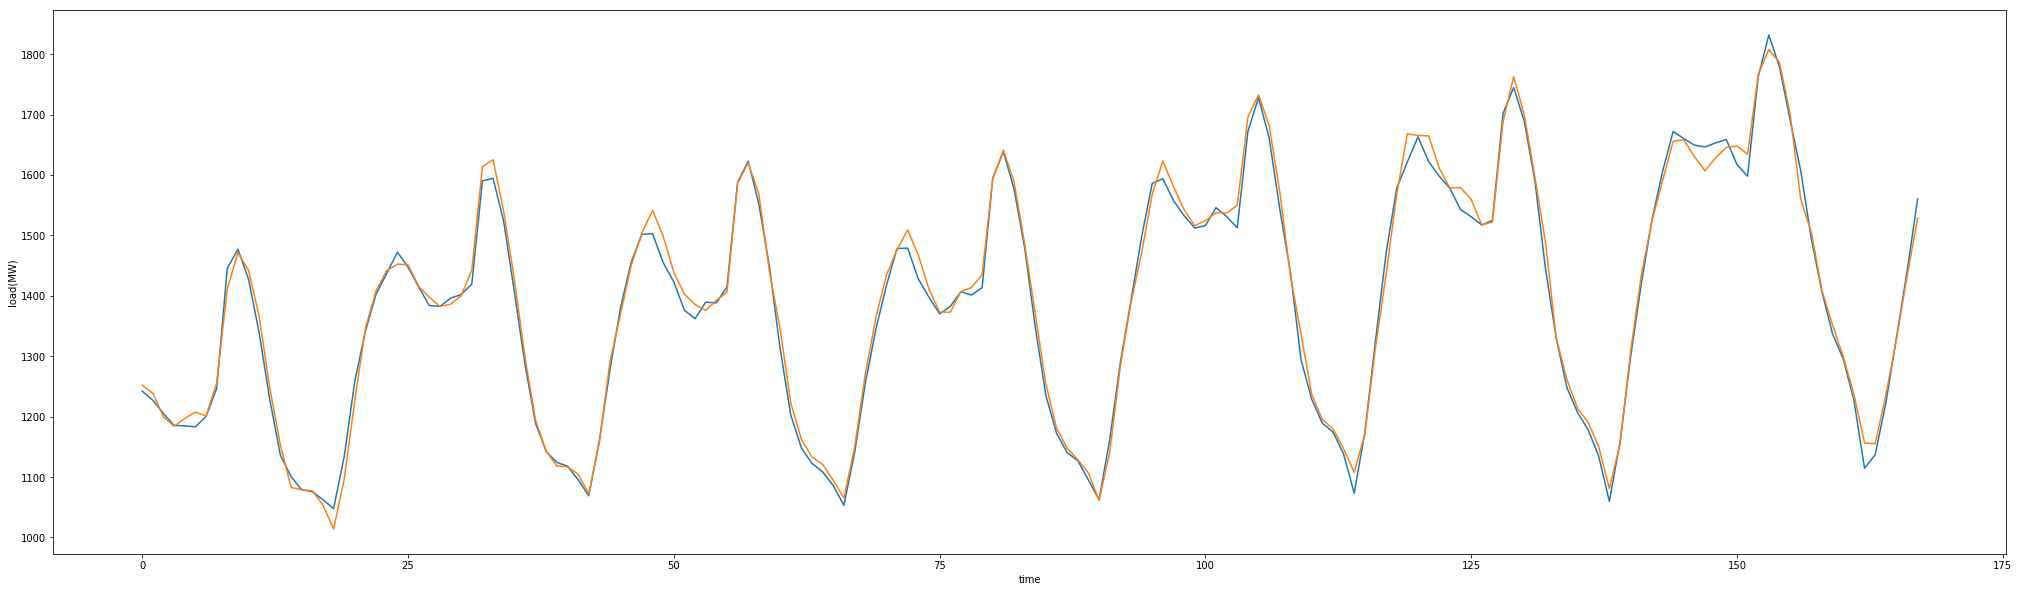

In [ ]:
def plotting(inv_y, inv_yhat, start_point, num_of_cols):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(35,10))
    pyplot.plot(inv_y[start_point:start_point+num_of_points], label='train')
    pyplot.plot(inv_yhat[start_point:start_point+num_of_points], label='test')
    pyplot.xlabel('time')
    pyplot.ylabel('load(MW)')
    plt.show()
    
    
num_of_points = 24*7
start_point = 1500

plotting(inv_y,inv_yhat,start_point,num_of_points)

In [ ]:
import json
import pandas as pd

testPredict2 = json.loads(pd.Series(inv_yhat).to_json(orient='values'))
s2 = json.loads(pd.Series(inv_y).to_json(orient='values'))
print(s2)
          
final_data = [testPredict2, s2]

file = open("resault_final_cs4.json", "w")
file.write(json.dumps(final_data, sort_keys=True, indent=5))
file.close()

[1326.945, 1275.997, 1203.571, 1050.827, 984.595, 963.616, 914.366, 926.954, 970.709, 1005.973, 1006.972, 993.386, 975.202, 952.028, 939.321, 925.572, 941.738, 985.594, 1191.184, 1295.515, 1286.786, 1270.2, 1248.8, 1193.791, 1255.3, 936.8, 1011.684, 965.714, 945.525, 937.555, 939.48, 889.582, 905.462, 965.884, 1044.332, 1071.006, 1070.654, 1062.5, 1050.1, 1036.857, 1039.86, 1072.1, 1148.8, 1327.245, 1381.4, 1358.0, 1325.25, 1281.646, 1195.579, 1086.4, 967.706, 976.702, 957.463, 948.283, 947.648, 892.955, 908.025, 969.481, 1040.961, 1080.551, 1114.132, 1116.43, 1096.54, 1086.08, 1099.62, 1113.923, 1147.628, 1325.247, 1377.372, 1355.009, 1329.622, 1299.8, 1229.9, 1123.873, 1048.9, 996.6, 984.098, 981.0, 964.608, 899.6, 935.977, 1006.338, 1063.642, 1088.664, 1067.709, 1053.984, 1035.712, 1023.7, 1024.5, 1030.8, 1085.791, 1318.043, 1392.3, 1377.797, 1351.989, 1308.432, 1229.0, 1125.8, 1064.042, 1016.381, 986.603, 990.213, 989.495, 959.5, 1017.354, 1094.115, 1161.892, 1217.821, 1201.287, 11

In [ ]:
import numpy as np

hour = 0
today_loads_pre = []
today_loads_act = []

print(int(len(testPredict2)/24))

mape_day = []
for i in range(0,len(testPredict2)):
    today_loads_pre.append(testPredict2[i])
    today_loads_act.append(s2[i])
    hour += 1
    if hour==24:
        mape_day.append(mean_absolute_percentage_error(np.array(today_loads_pre),np.array(today_loads_act)))
        hour = 0
        today_loads_pre = []
        today_loads_act = []
# print(mape_day)


DMEH2 = 0
DMEH4 = 0

for i in mape_day:
    if i>3:
        DMEH2+=1
        if i>6:
            DMEH4+=1
            
print(DMEH2)
print(DMEH4)
            

363
12
0


In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    import numpy as np
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def dme(inv_y, inv_yhat):
    all_days_max_mape = []
    
    hour = 0
    day_mape = []
    for i in range(0, len(inv_y)):
        day_mape.append(mean_absolute_percentage_error(inv_y[i], inv_yhat[i]))
        hour += 1
        if hour == 24:
            all_days_max_mape.append(max(day_mape))
            print(day_mape)
            day_mape = []
            hour = 0
            
    print(all_days_max_mape)
    return sum(all_days_max_mape)/len(all_days_max_mape)


import json
import numpy as np

f = open('/content/drive/My Drive/Short_Term_Load_Prediction_NN/final_reasults/resault_final_cs4.json', "r")

contents = ""
if f.mode == 'r':
    contents = f.read()
dataset = json.loads(contents)

print(dme(dataset[0], dataset[1]))
print(mean_absolute_percentage_error(np.array(dataset[0]), np.array(dataset[1])))


def dme6(inv_y, inv_yhat):
    all_days_max_mape = []
    
    hour = 0
    day_mape = []
    for i in range(0, len(inv_y)):
        day_mape.append(mean_absolute_percentage_error(inv_y[i], inv_yhat[i]))
        hour += 1
        if hour == 24:
            all_days_max_mape.append(max(day_mape))
            day_mape = []
            hour = 0
    
    DMEH6 = 0
    for i in all_days_max_mape:
        if i>6:
            DMEH6 += 1
            
    
    return DMEH6


print(dme6(dataset[0], dataset[1]))

[1.3211312483564215, 2.665161454716067, 1.0415534146006897, 9.813058021567468, 5.153709751449947, 2.6806954323362895, 3.177478139733061, 0.6085847486851927, 3.260365196303842, 5.297468394293125, 6.186290485792409, 4.727958779479142, 1.9373737690622377, 1.754379048076505, 0.9114207208333267, 1.5236807760692481, 0.527602943964571, 1.240256589519686, 2.5848339537417813, 0.4537538095984273, 2.0612808570082186, 0.1616281194328801, 0.9711324485951168, 0.00736189444141804]
[11.681195462206349, 21.631282772502345, 14.053843854135566, 3.9590475358231507, 2.203036319257405, 0.49512791200277256, 3.3301170540079186, 6.621082861410224, 3.656635844256442, 1.1926426459030703, 5.7718422501498035, 2.800926919304253, 2.1213949266881076, 2.0107067217860264, 0.48196586417673754, 0.2736365220974328, 0.39413608382344084, 0.328211147568822, 5.487109526434227, 6.485239154913347, 3.269812497282064, 0.5013795313102448, 0.06088064303564707, 1.396082271095211]
[5.852766399292831, 6.355780920270659, 9.300500032835

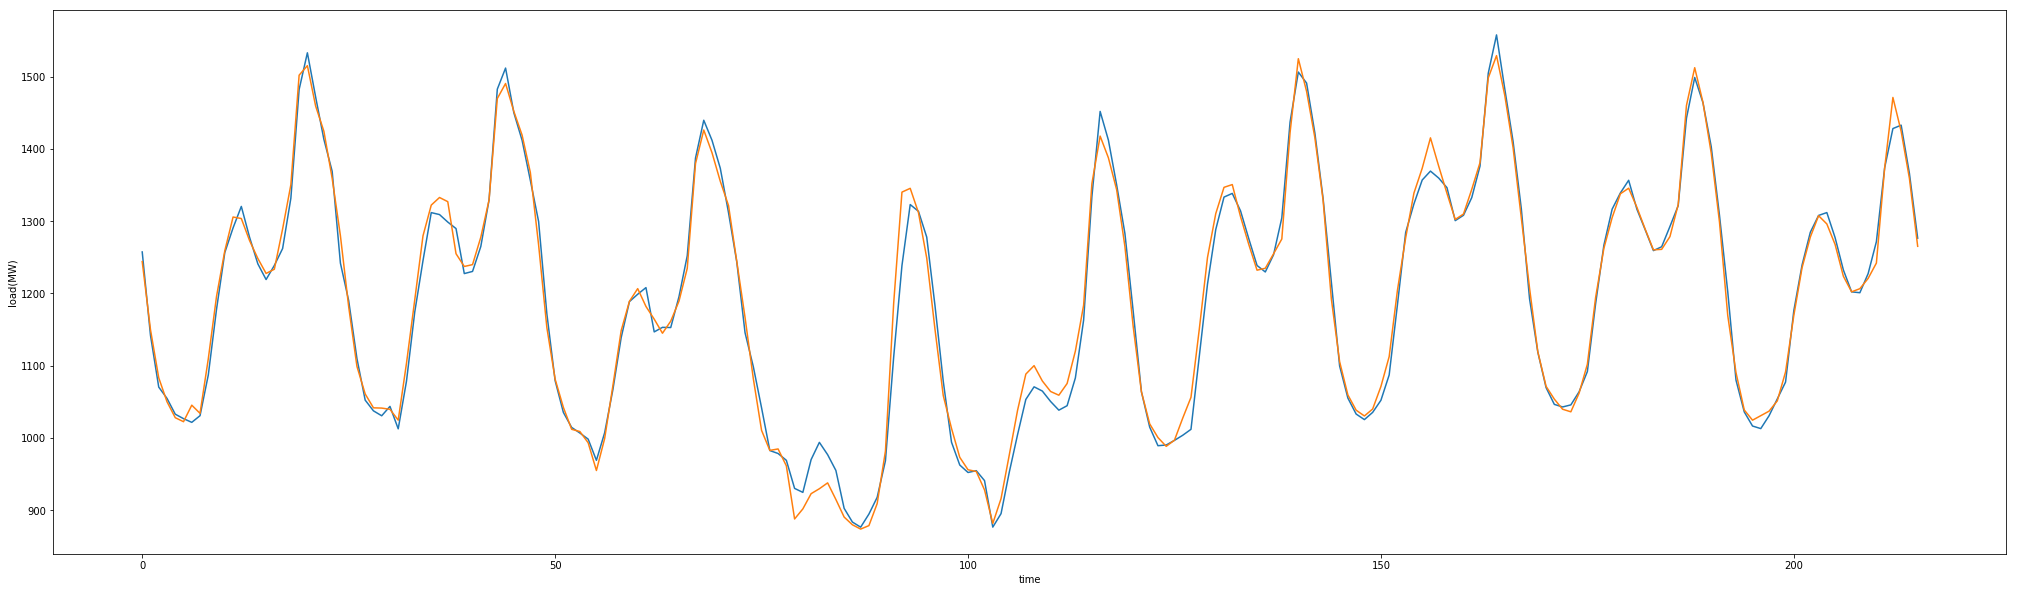

In [ ]:
def plotting(inv_y, inv_yhat, start_point, num_of_cols):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(35,10))
    plt.plot(inv_y[start_point:start_point+num_of_points], label='train')
    plt.plot(inv_yhat[start_point:start_point+num_of_points], label='test')
    plt.xlabel('time')
    plt.ylabel('load(MW)')
    plt.show()
    
    
num_of_points = 24*9
start_point = 24*9

plotting(dataset[0], dataset[1],start_point,num_of_points)

In [ ]:
import xlwt 

y_new = []
y_day = []
ind = 0
for i in inv_y:
    y_day.append(i)
    ind += 1
    if ind == 24:
        ind = 0
        y_new.append(y_day)
        y_day = []
    
y_new_pre = []
y_day_pre = []
ind = 0
for i in inv_yhat:
    y_day_pre.append(i)
    ind += 1
    if ind == 24:
        ind = 0
        y_new_pre.append(y_day_pre)
        y_day_pre = []

        
# writing
workbook = xlwt.Workbook()
sheet = workbook.add_sheet('actual')
new_row = 0
style = xlwt.XFStyle()
style.num_format_str = 'YY-M-D h:mm'  # Other options: D-MMM-YY, D-MMM, MMM-YY, h:mm, h:mm:ss, h:mm, h:mm:ss, M/D/YY h:mm, mm:ss, [h]:mm:ss, mm:ss.0

dy=1394
dm=1
dd=1


for i in range(0, 202):
    sheet.write(i, 0, dy)
    sheet.write(i, 1, dm)
    sheet.write(i, 2, dd)
    for j in range(0,24):
        sheet.write(i, 3+j, y_new[i][j])
    dd += 1
    if dd == 32:
        dd = 1
        dm += 1

        
            
        
sheet = workbook.add_sheet('predicted')
dy=1394
dm=1
dd=1


for i in range(0, 202):
    sheet.write(i, 0, dy)
    sheet.write(i, 1, dm)
    sheet.write(i, 2, dd)
    for j in range(0,24):
        sheet.write(i, 3+j, y_new_pre[i][j])    
    dd += 1
    if dd == 32:
        dd = 1
        dm += 1
workbook.save("a.xls")